In [1]:
 !pip install pytorch-pretrained-bert

    100% |████████████████████████████████| 51kB 18.7MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 29.2MB/s ta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
! git clone https://github.com/NVIDIA/apex.git

Cloning into 'apex'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2323 (delta 58), reused 73 (delta 34), pack-reused 2207
Receiving objects: 100% (2323/2323), 7.87 MiB | 37.14 MiB/s, done.
Resolving deltas: 100% (1415/1415), done.


In [2]:
!g++ --version

g++ (GCC) 4.8.5 20150623 (Red Hat 4.8.5-28)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [7]:
#  !python search_data/apex/setup.py install --cuda_ext
# import apex

torch.__version__  =  0.4.1
running install
running bdist_egg
running egg_info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
reading manifest file 'apex.egg-info/SOURCES.txt'
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (g++ 4.8) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!

In [3]:
import logging
import os
import argparse
import random
from tqdm import tqdm, trange
import csv

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForMultipleChoice
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE


In [5]:
header = ['query_id', 'query', 'passage_text', 'label', 'passage_id']
test_header = ['query_id', 'query', 'passage_text', 'passage_id']

In [6]:
# import boto3

In [7]:
# train = pd.read_csv('./search_data/data.tsv',delimiter='\t',names=header)


In [8]:
test = pd.read_csv('./search_data/eval2_unlabelled.tsv',delimiter='\t',names=test_header)

In [9]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [10]:
class InputFeatures(object):
    def __init__(self,
                 example_id,
                 choices_features,
                 label

    ):
        self.example_id = example_id
        self.choices_features = [
            {
                'input_ids': input_ids,
                'input_mask': input_mask,
                'segment_ids': segment_ids
            }
            for _, input_ids, input_mask, segment_ids in choices_features
        ]
        self.label = label




In [10]:
# sorted_train_data = train.sort_values(['query_id','passage_id'])

In [11]:
# train[train.query_id ==1]

In [ ]:
# sorted_train_data.to_csv('./data/sorted_train.csv',index=False)

In [11]:
# sorted_train_data = test[:5587]

## Test data analysis

In [12]:
test

,query_id,query,passage_text,passage_id
0,1136966,#ffffff color code,Color hex is a easy to use tool to get the col...,0
1,1136966,#ffffff color code,#ffffff Color Conversion. The hexadecimal colo...,1
2,1136966,#ffffff color code,CSS Codes; Color Preview; Color Schemes; Color...,2
3,1136966,#ffffff color code,Color Hex Color Codes Color-hex gives informat...,3
4,1136966,#ffffff color code,Color Hex Color Codes. Color-hex gives informa...,4
5,1136966,#ffffff color code,Color information. #FFFFFF (or 0xFFFFFF) is kn...,5
6,1136966,#ffffff color code,"#ffffff color RGB value is (255,255,255). This...",6
7,1136966,#ffffff color code,Color Schemes with #ffffff. 1 #d9d9d9 #d9d9d9...,7
8,1136966,#ffffff color code,Having a set of related colors can be useful i...,8
9,1136966,#ffffff color code,Hex color #FFFFFF is a web safe color. Inverse...,9


In [13]:
test['combined'] = test['query'] + ' ' + test['passage_text']

### Checking the sequence length distribution on test set

In [16]:
test['seq_length'] = test['combined'].apply(lambda x: len(x.split()))

In [17]:
test

,query_id,query,passage_text,passage_id,combined,seq_length
0,1136966,#ffffff color code,Color hex is a easy to use tool to get the col...,0,#ffffff color code Color hex is a easy to use ...,28
1,1136966,#ffffff color code,#ffffff Color Conversion. The hexadecimal colo...,1,#ffffff color code #ffffff Color Conversion. T...,30
2,1136966,#ffffff color code,CSS Codes; Color Preview; Color Schemes; Color...,2,#ffffff color code CSS Codes; Color Preview; C...,99
3,1136966,#ffffff color code,Color Hex Color Codes Color-hex gives informat...,3,#ffffff color code Color Hex Color Codes Color...,65
4,1136966,#ffffff color code,Color Hex Color Codes. Color-hex gives informa...,4,#ffffff color code Color Hex Color Codes. Colo...,51
5,1136966,#ffffff color code,Color information. #FFFFFF (or 0xFFFFFF) is kn...,5,#ffffff color code Color information. #FFFFFF ...,34
6,1136966,#ffffff color code,"#ffffff color RGB value is (255,255,255). This...",6,#ffffff color code #ffffff color RGB value is ...,87
7,1136966,#ffffff color code,Color Schemes with #ffffff. 1 #d9d9d9 #d9d9d9...,7,#ffffff color code Color Schemes with #ffffff....,23
8,1136966,#ffffff color code,Having a set of related colors can be useful i...,8,#ffffff color code Having a set of related col...,39
9,1136966,#ffffff color code,Hex color #FFFFFF is a web safe color. Inverse...,9,#ffffff color code Hex color #FFFFFF is a web ...,82


In [20]:
max(test['seq_length']), min(test['seq_length'])

(286, 3)

In [21]:
test.describe()

,query_id,passage_id,seq_length
count,4.153800e+05,415380.000000,415380.000000
mean,7.641694e+05,4.500000,57.130247
std,3.691768e+05,2.872285,19.467680
min,5.700000e+01,0.000000,3.000000
25%,4.566740e+05,2.000000,45.000000
50%,8.695660e+05,4.500000,54.000000
75%,1.113454e+06,7.000000,64.000000
max,1.136966e+06,9.000000,286.000000


In [23]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57f43d0748>]],
      dtype=object)

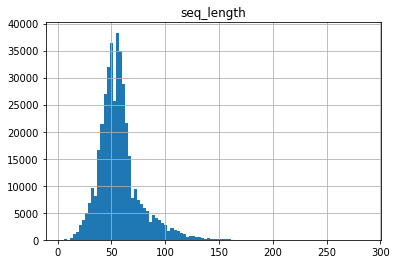

In [55]:
test.hist(column='seq_length',bins = 100)

In [11]:
import pickle

In [12]:
rr_file = open('./search_data/new_bhokal_df','rb')

In [13]:
sorted_train_data = pickle.load(rr_file)
# pd.read_csv('./search_data/new/sorted_train.csv')

## Main methods to process input data

In [12]:
def convert_examples_to_features_test(examples, tokenizer, max_seq_length):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
#     for example_index, example in examples.iterrows():
    for example_index in range(0,examples.shape[0],10):
        
        example = examples.iloc[example_index]
        context_tokens = tokenizer.tokenize(example['query'])
        start_ending_tokens = tokenizer.tokenize('')
        
        choices_features = []
        one_ques = examples[example_index:example_index+10]
        
        #since this is test data
        label = None
        
        endings = one_ques['passage_text']
        for ending_index, ending in enumerate(endings):
            # We create a copy of the context tokens in order to be
            # able to shrink it according to ending_tokens
            context_tokens_choice = context_tokens[:]
            ending_tokens = start_ending_tokens + tokenizer.tokenize(ending)
            # Modifies `context_tokens_choice` and `ending_tokens` in
            # place so that the total length is less than the
            # specified length.  Account for [CLS], [SEP], [SEP] with
            # "- 3"
            _truncate_seq_pair(context_tokens_choice, ending_tokens, max_seq_length-3)

            tokens = ["[CLS]"] + context_tokens_choice + ["[SEP]"] + ending_tokens + ["[SEP]"]
            segment_ids = [0] * (len(context_tokens_choice) + 2) + [1] * (len(ending_tokens) + 1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            input_mask += padding
            segment_ids += padding

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            choices_features.append((tokens, input_ids, input_mask, segment_ids))
#         if(example.query_id%5000==0):
#             print(example.query_id)
#         if example_index < 5:
#             logger.info("*** Example ***")
#             logger.info(f"query_id: {example.query_id}")
#             for choice_idx, (tokens, input_ids, input_mask, segment_ids) in enumerate(choices_features):
#                 logger.info(f"choice: {choice_idx}")
#                 logger.info(f"tokens: {' '.join(tokens)}")
#                 logger.info(f"input_ids: {' '.join(map(str, input_ids))}")
#                 logger.info(f"input_mask: {' '.join(map(str, input_mask))}")
#                 logger.info(f"segment_ids: {' '.join(map(str, segment_ids))}")
        if example_index % 1000 == 0:
            print (example_index)
            
        features.append(
            InputFeatures(
                example_id = example.query_id,
                choices_features = choices_features,
                label = label
            )
        )

    return features


In [13]:
def convert_examples_to_features(examples, tokenizer, max_seq_length,
                                 is_training):
    """Loads a data file into a list of `InputBatch`s."""

    # Swag is a multiple choice task. To perform this task using Bert,
    # we will use the formatting proposed in "Improving Languagea
    # Understanding by Generative Pre-Training" and suggested by
    # @jacobdevlin-google in this issue
    # https://github.com/google-research/bert/issues/38.
    #
    # Each choice will correspond to a sample on which we run the
    # inference. For a given Swag example, we will create the 4
    # following inputs:
    # - [CLS] context [SEP] choice_1 [SEP]
    # - [CLS] context [SEP] choice_2 [SEP]
    # - [CLS] context [SEP] choice_3 [SEP]
    # - [CLS] context [SEP] choice_4 [SEP]
    # The model will output a single value for each input. To get the
    # final decision of the model, we will run a softmax over these 4
    # outputs.
    features = []
#     for example_index, example in examples.iterrows():
    for example_index in range(0,examples.shape[0],10):
        
        example = examples.iloc[example_index]
        context_tokens = tokenizer.tokenize(example['query'])
        start_ending_tokens = tokenizer.tokenize('')
        
        choices_features = []
        one_ques = examples[example_index:example_index+10]
        
        label = None
        
        if is_training:
            
            try:
                label = one_ques[one_ques.label==1].iloc[0]['passage_id']
            except Exception as e:
                print(e)
                print(one_ques)
        
        endings = one_ques['passage_text']
        for ending_index, ending in enumerate(endings):
            # We create a copy of the context tokens in order to be
            # able to shrink it according to ending_tokens
            context_tokens_choice = context_tokens[:]
            ending_tokens = start_ending_tokens + tokenizer.tokenize(ending)
            # Modifies `context_tokens_choice` and `ending_tokens` in
            # place so that the total length is less than the
            # specified length.  Account for [CLS], [SEP], [SEP] with
            # "- 3"
            _truncate_seq_pair(context_tokens_choice, ending_tokens, max_seq_length-3)

            tokens = ["[CLS]"] + context_tokens_choice + ["[SEP]"] + ending_tokens + ["[SEP]"]
            segment_ids = [0] * (len(context_tokens_choice) + 2) + [1] * (len(ending_tokens) + 1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            input_mask += padding
            segment_ids += padding

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            choices_features.append((tokens, input_ids, input_mask, segment_ids))
#         if(example.query_id%5000==0):
#             print(example.query_id)
        if example_index < 5:
            logger.info("*** Example ***")
            logger.info(f"query_id: {example.query_id}")
            for choice_idx, (tokens, input_ids, input_mask, segment_ids) in enumerate(choices_features):
                logger.info(f"choice: {choice_idx}")
                logger.info(f"tokens: {' '.join(tokens)}")
                logger.info(f"input_ids: {' '.join(map(str, input_ids))}")
                logger.info(f"input_mask: {' '.join(map(str, input_mask))}")
                logger.info(f"segment_ids: {' '.join(map(str, segment_ids))}")
            if is_training:
                logger.info(f"label: {label}")

        features.append(
            InputFeatures(
                example_id = example.query_id,
                choices_features = choices_features,
                label = label
            )
        )

    return features


In [14]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def select_field(features, field):
    return [
        [
            choice[field]
            for choice in feature.choices_features
        ]
        for feature in features
    ]

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

## Evaluation functions - Accuracy and Mean Reciprocal Rank

In [ ]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)


def get_mrr2(logits,labels):
    
#     ranks = np.argsort(logits,axis=1)[::-1]
    sum1 = 0.0
    count = 0
    for i in range(len(labels)):
        rank = np.argsort(logits[i])[::-1]
        l = labels[i]
#     for l in labels:
        sum1 +=1/(np.where(rank==l)[0][0]+1)
        count+=1
        
        
    return sum1

In [15]:
class args:
    
    bert_model = "bert-base-uncased"
    do_train = True
    do_lower_case = True
    do_eval = True
    #data_dir = "./search_data/swagaf/data/"
    train_batch_size = 240
    learning_rate = 2e-5
    num_train_epochs = 1.0
    max_seq_length = 290
    output_dir = "./search_data/swagaf/output_data_all/"
    gradient_accumulation_steps = 10
    
    ### default attribs
    local_rank = -1
    no_cuda = False
    seed = 42
    fp16  = False
    warmup_proportion = 0.1
    loss_scale = 0
    eval_batch_size = 30
    
    
    

In [16]:
args.train_batch_size , args.gradient_accumulation_steps ,args.num_train_epochs

(240, 10, 1.0)

In [17]:
args.train_batch_size / args.gradient_accumulation_steps

24.0

In [ ]:
if args.local_rank == -1 or args.no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
    device, n_gpu, bool(args.local_rank != -1), args.fp16))

if args.gradient_accumulation_steps < 1:
    raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(
                        args.gradient_accumulation_steps))

args.train_batch_size = int(args.train_batch_size / args.gradient_accumulation_steps)

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(args.seed)

if not args.do_train and not args.do_eval:
    raise ValueError("At least one of `do_train` or `do_eval` must be True.")

if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
os.makedirs(args.output_dir, exist_ok=True)

tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

train_examples = None
num_train_steps = None

#### Run when in training mode

In [18]:
# if args.do_train:
# #     train_examples_orig = read_swag_examples(os.path.join(args.data_dir, 'train.csv'), is_training = True)
#     train_examples_orig = sorted_train_data
#     print ("Total Training Examples length " + str(len(train_examples_orig)))
    
#     # taking only 100 examples for now
#     train_examples = train_examples_orig
#     num_train_steps = int(
#         len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps * args.num_train_epochs)
#     print ("Taking Training Examples length " + str(len(train_examples)))
#     print ("Num Train Steps " + str(num_train_steps))

12/29/2018 09:41:34 - INFO - __main__ -   device: cuda n_gpu: 8, distributed training: False, 16-bits training: False
12/29/2018 09:41:34 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpwlpencui
100%|██████████| 231508/231508 [00:00<00:00, 27068881.87B/s]
12/29/2018 09:41:34 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpwlpencui to cache at /home/ec2-user/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
12/29/2018 09:41:34 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /home/ec2-user/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
12/29/2018 09:41:34 - INFO - pytorch_pretrained_bert.file_utils -   removing temp

In [22]:
num_train_steps = 287480 / args.train_batch_size / args.gradient_accumulation_steps * args.num_train_epochs
num_train_steps

1197.8333333333335

In [19]:
# train_examples = sorted_train_data

In [20]:
# from apex.parallel import DistributedDataParallel as DDP

## Load BERT Model , use one of the two options

In [39]:
# use google provided models 
model = BertForMultipleChoice.from_pretrained(args.bert_model,
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
    num_choices=10)


12/29/2018 10:14:43 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/ec2-user/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
12/29/2018 10:14:43 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/ec2-user/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp2pwlzyok
12/29/2018 10:14:47 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_la

In [93]:
# OR Load a trained model that you have fine-tuned
model_state_dict = torch.load('./search_data/swagaf/output_data_all_160_epoch_2/pytorch_model.bin')
model = BertForMultipleChoice.from_pretrained(args.bert_model,
    state_dict=model_state_dict,
    num_choices=10)


12/29/2018 10:45:11 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/ec2-user/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
12/29/2018 10:45:11 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/ec2-user/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp5vev9031
12/29/2018 10:45:15 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size"

In [ ]:
if args.fp16:
    model.half()

model.to(device)
if args.local_rank != -1:
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    model = DDP(model)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

## Prepare optimizer

In [94]:

param_optimizer = list(model.named_parameters())

# hack to remove pooler, which is not used
# thus it produce None grad that break apex
param_optimizer = [n for n in param_optimizer if 'pooler' not in n[0]]

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
t_total = num_train_steps
if args.local_rank != -1:
    t_total = t_total // torch.distributed.get_world_size()
if args.fp16:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    optimizer = FusedAdam(optimizer_grouped_parameters,
                          lr=args.learning_rate,
                          bias_correction=False,
                          max_grad_norm=1.0)
    if args.loss_scale == 0:
        optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
    else:
        optimizer = FP16_Optimizer(optimizer, static_loss_scale=args.loss_scale)
else:
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=args.learning_rate,
                         warmup=args.warmup_proportion,
                         t_total=t_total)


## Trying Multi-threading for Input processing

Since the training data was huge (5.2 Million rows) we tried multi-thread processing for converting raw-text to our specified input format (specifically to  InputFeatures class). But this was taking extravagant memory and made the notebook unreponsive even on 32 Cores, 200 GB Memory machine.  

### Eventually we used df.apply() which processed 5.2 Million rows in ~1.5 hours on single thread

In [ ]:
#testing
from multiprocessing import Pool

def f(x):
    return [x*x]

with Pool(5) as p:
        nums = p.map(f, [1, 2, 3])

In [24]:
features_list = []

In [ ]:
def convert_examples_to_features_parellel_test(train_examples):
    train_features = convert_examples_to_features(
        train_examples, tokenizer, args.max_seq_length, False)
    return train_features

In [ ]:
def convert_examples_to_features_parellel(train_examples,is_training):
    train_features = convert_examples_to_features(
        train_examples, tokenizer, args.max_seq_length, is_training)
    return train_features

In [34]:
import time

In [35]:
time.time()

1546059811.0388947

In [48]:
start = time.time()
test_features = convert_examples_to_features_test(test, tokenizer, args.max_seq_length)
print((time.time()-start)/60)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [49]:
a = test_features[0]

In [ ]:
a.choices_features,a.label

In [ ]:
# dfs = [sorted_train_data[i:i+500] for i in range(0,sorted_train_data.shape[0],500)]
    

In [27]:
dfs = [train_examples_orig[i:i+500] for i in range(0,train_examples_orig.shape[0],500)]

In [28]:
dfs[0].head()

,query_id,query,passage_text,label,passage_id
0,1,Androgen receptor define,"The androgen receptor (AR), also known as NR3C...",1,0
1,1,Androgen receptor define,The AR gene provides instructions for making a...,0,1
2,1,Androgen receptor define,The androgen receptor gene is more than 90 kb ...,0,2
3,1,Androgen receptor define,Mutations in the AR gene cause androgen insens...,0,3
4,1,Androgen receptor define,Normal function of the androgen receptor. Test...,0,4


In [ ]:
def convert_examples_with_pool(dfs,threads=4,is_training=True):
    with Pool(threads) as p:
         f_list = p.map(convert_examples_to_features_parellel,dfs)
    return f_list


In [44]:
from multiprocessing import Pool

In [ ]:
from multiprocessing import Pool


with Pool(16) as p:
     f_list = p.map(convert_examples_to_features_parellel,dfs)

In [30]:
len(f_list)

400

## Pickling

In [51]:
import pickle

In [ ]:
# Saving test data processed.
# file = open('./search_data/test_2_list_all_290', 'wb')
# pickle.dump(test_features,file)

In [35]:
r_file = open('./search_data/f_list_all', 'rb')
f_list_all = pickle.load(r_file)

In [25]:
# Since our dataset is 10-class classification
len(f_list_all)

524188

In [56]:
# del model

In [58]:
## To clear out unused GPU and CPU memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
# to utilize a variable across all jupyter notebooks
# %store f_list

In [52]:
args.max_seq_length

290

## Training

Running on a small dataset here, in Competition we ran 2 models on complete training data- 
1. 2 Epochs, 1st with 120 max_seq_length, 2nd with 160 max_seq_length
2. 3 Epochs, 1st with 120 max_seq_length, 2nd with 160 max_seq_length, 3rd with 198 max_seq_length

In [24]:
args.do_train

True

In [29]:
if args.do_train:
#     train_features = convert_examples_to_features(
#         train_examples, tokenizer, args.max_seq_length, True)
    train_features = f_list_all
    print("***** Running training *****")
    print("  Num examples = %d", len(train_features))
    logger.info("  Batch size = %d", args.train_batch_size)
    logger.info("  Num steps = %d", num_train_steps)
    all_input_ids = torch.tensor(select_field(train_features, 'input_ids'), dtype=torch.long)
    all_input_mask = torch.tensor(select_field(train_features, 'input_mask'), dtype=torch.long)
    all_segment_ids = torch.tensor(select_field(train_features, 'segment_ids'), dtype=torch.long)
    all_label = torch.tensor([f.label for f in train_features], dtype=torch.long)
    train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label)
    if args.local_rank == -1:
        train_sampler = RandomSampler(train_data)
    else:
        train_sampler = DistributedSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args.train_batch_size)


12/26/2018 18:11:14 - INFO - __main__ -     Batch size = 24
12/26/2018 18:11:14 - INFO - __main__ -     Num steps = 1197


***** Running training *****
  Num examples = %d 28261


In [82]:
train_dataloader

In [29]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [81]:
args.num_train_epochs

1.0

In [30]:
global_step = 0
if args.do_train:
    model.train()
    for _ in trange(int(args.num_train_epochs), desc="Epoch"):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if args.fp16 and args.loss_scale != 1.0:
                # rescale loss for fp16 training
                # see https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html
                loss = loss * args.loss_scale
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1

            if args.fp16:
                optimizer.backward(loss)
            else:
                loss.backward()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                # modify learning rate with special warm up BERT uses
                lr_this_step = args.learning_rate * warmup_linear(global_step/t_total, args.warmup_proportion)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_this_step
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1



Iteration:   0%|          | 0/1178 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:58: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Iteration:  21%|██        | 247/1178 [02:30<06:30,  2.39it/s]


Iteration:  42%|████▏     | 499/1178 [04:27<04:49,  2.34it/s]


Iteration:  64%|██████▍   | 751/1178 [06:24<03:02,  2.34it/s]


Iteration:  85%|████████▌ | 1002/1178 [08:21<01:22,  2.12it/s]


Epoch: 100%|██████████| 1/1 [09:42<00:00, 582.43s/it]


In [31]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = os.path.join(args.output_dir, "pytorch_model.bin")
torch.save(model_to_save.state_dict(), output_model_file)



In [26]:
# Load a trained model that you have fine-tuned
# model_state_dict = torch.load('./search_data/swagaf/output_data_all/pytorch_model.bin')
# model = BertForMultipleChoice.from_pretrained(args.bert_model,
#     state_dict=model_state_dict,
#     num_choices=10)
# model.to(device)

In [ ]:
# model_state_dict = torch.load('./search_data/swagaf/output_data_2/pytorch_model.bin')
# model = BertForMultipleChoice.from_pretrained(args.bert_model,
#     state_dict=model_state_dict,
#     num_choices=10)
# model.to(device)

In [ ]:
test['label'] = None

In [ ]:
test.head()

In [39]:
test.shape

(104170, 4)

In [40]:
test_dfs = [test[i:i+500] for i in range(0,test.shape[0],500)]

In [51]:
test_orig = convert_examples_with_pool(test_dfs,4,False)

In [64]:
len(test_orig)

209

In [65]:
test_orig

[[<__main__.InputFeatures at 0x7f24bc7c3550>,

In [66]:
test_list_all = []
[test_list_all.extend(i) for i in test_orig]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
len(test_list_all)

In [68]:
test_list_all[1]

In [ ]:
# test_orig = convert_examples_to_features(test, tokenizer, args.max_seq_length, False)

In [69]:
args.eval_batch_size = 80

## Checking MRR on Eval set

In [43]:

final_result = []

if args.do_eval and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
#     eval_examples = read_swag_examples(os.path.join(args.data_dir, 'val.csv'), is_training = True)
#     eval_examples = train[-4000:]
#     eval_features = convert_examples_to_features(
#         eval_examples, tokenizer, args.max_seq_length, True)
    eval_features = f_list_all[4000:9000]
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_features))
    logger.info("  Batch size = %d", args.eval_batch_size)
    all_input_ids = torch.tensor(select_field(eval_features, 'input_ids'), dtype=torch.long)
    all_input_mask = torch.tensor(select_field(eval_features, 'input_mask'), dtype=torch.long)
    all_segment_ids = torch.tensor(select_field(eval_features, 'segment_ids'), dtype=torch.long)
    all_label = torch.tensor([f.label for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    eval_mrr = 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for input_ids, input_mask, segment_ids, label_ids in eval_dataloader:
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        logits = logits.detach().cpu().numpy()
        [final_result.append(l) for l in logits]
        
        label_ids = label_ids.to('cpu').numpy()
        
        eval_mrr += get_mrr2(logits,label_ids)
        
        #final_result.append(logits)
        
        
        if(nb_eval_steps % 100 == 0):
            print (nb_eval_steps)
#             print(logits)
#             print(label_ids)
        
        tmp_eval_accuracy = accuracy(logits, label_ids)

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    eval_mrr = eval_mrr/nb_eval_examples

    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,
#               'global_step': global_step,
#               'loss': tr_loss/nb_tr_steps,
              'eval_mrr': eval_mrr}

    output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))



12/29/2018 10:20:29 - INFO - __main__ -   ***** Running evaluation *****
12/29/2018 10:20:29 - INFO - __main__ -     Num examples = 5000
12/29/2018 10:20:29 - INFO - __main__ -     Batch size = 30
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:58: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0
100


12/29/2018 10:21:38 - INFO - __main__ -   ***** Eval results *****
12/29/2018 10:21:38 - INFO - __main__ -     eval_accuracy = 0.5276
12/29/2018 10:21:38 - INFO - __main__ -     eval_loss = 1.2896398434382
12/29/2018 10:21:38 - INFO - __main__ -     eval_mrr = 0.6976818253968254


In [41]:
# Empty the GPU memory
import gc
gc.collect()
torch.cuda.empty_cache()

## Predicting on Test-Set

In [71]:
# r_file1 = open('./search_data/test_features_list_all', 'rb') # Phase-1 Test Set
r_file1 = open('./search_data/test_2_features_list_all_290', 'rb') # Phase-2 Test Set
test_list_all = pickle.load(r_file1)

In [73]:
test.shape

(415380, 4)

In [72]:
len(test_list_all)

41538

In [100]:
# a = test_list_all[1]
# len(a.choices_features[0]['input_ids']),a.choices_features[0]

(290,
 {'input_ids': [101,
   2339,
   2106,
   1996,
   9747,
   8998,
   21754,
   1029,
   102,
   2348,
   1996,
   2647,
   4204,
   2106,
   2191,
   2510,
   19388,
   1999,
   3763,
   2637,
   2013,
   2051,
   2000,
   2051,
   2044,
   1996,
   9747,
   8998,
   2001,
   2623,
   1010,
   1996,
   4841,
   2106,
   2025,
   2298,
   2005,
   2162,
   1012,
   2027,
   2106,
   1010,
   2174,
   1010,
   2224,
   1996,
   8998,
   2004,
   19777,
   2005,
   2635,
   3146,
   1999,
   10008,
   2104,
   2343,
   2198,
   7482,
   1012,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [101]:
args.eval_batch_size = 140

In [102]:
# def main():

final_result = []

if args.do_eval and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
#     eval_examples = read_swag_examples(os.path.join(args.data_dir, 'val.csv'), is_training = True)
#     eval_examples = train[4000:8000]
    
    eval_features = test_list_all
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_features))
    logger.info("  Batch size = %d", args.eval_batch_size)
    all_input_ids = torch.tensor(select_field(eval_features, 'input_ids'), dtype=torch.long)
    all_input_mask = torch.tensor(select_field(eval_features, 'input_mask'), dtype=torch.long)
    all_segment_ids = torch.tensor(select_field(eval_features, 'segment_ids'), dtype=torch.long)
#     all_label = torch.tensor([f.label for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    model.eval()
#     eval_loss, eval_accuracy = 0, 0
#     eval_mrr = 0
#     nb_eval_steps, nb_eval_examples = 0, 0
    for input_ids, input_mask, segment_ids in eval_dataloader:
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
#         label_ids = label_ids.to(device)

        with torch.no_grad():
#             tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        logits = logits.detach().cpu().numpy()
        [final_result.append(l) for l in logits]
        
#         label_ids = label_ids.to('cpu').numpy()
        
#         eval_mrr += get_mrr2(logits,label_ids)
        
        #final_result.append(logits)
        
        
#         if(nb_eval_steps % 100 == 0):
#             print(nb_eval_steps)
#             print(label_ids)
        
#         tmp_eval_accuracy = accuracy(logits, label_ids)

#         eval_loss += tmp_eval_loss.mean().item()
#         eval_accuracy += tmp_eval_accuracy

#         nb_eval_examples += input_ids.size(0)
#         nb_eval_steps += 1

#     eval_loss = eval_loss / nb_eval_steps
#     eval_accuracy = eval_accuracy / nb_eval_examples
#     eval_mrr = eval_mrr/nb_eval_examples

#     result = {'eval_loss': eval_loss,
#               'eval_accuracy': eval_accuracy,
#               'global_step': global_step,
#               'loss': tr_loss/nb_tr_steps,
#               'eval_mrr': eval_mrr}

#     output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
#     with open(output_eval_file, "w") as writer:
#         logger.info("***** Eval results *****")
#         for key in sorted(result.keys()):
#             logger.info("  %s = %s", key, str(result[key]))
#             writer.write("%s = %s\n" % (key, str(result[key])))

12/29/2018 10:48:42 - INFO - __main__ -   ***** Running evaluation *****
12/29/2018 10:48:42 - INFO - __main__ -     Num examples = 41538
12/29/2018 10:48:42 - INFO - __main__ -     Batch size = 140


In [103]:
len(final_result)

41538

In [30]:
test.head()

,query_id,query,passage_text,passage_id
0,1135787,distance between erie in buffalo new york,Erie Canal Distance Tables The Erie Canal is t...,0
1,1135787,distance between erie in buffalo new york,What is the distance between Erie AND Buffalo?...,1
2,1135787,distance between erie in buffalo new york,The distance between Erie and Buffalo in a str...,2
3,1135787,distance between erie in buffalo new york,Erie Canal Distances. Erie Canal Distance Tabl...,3
4,1135787,distance between erie in buffalo new york,Erie's Metropolitan Area consists of approxima...,4


In [ ]:
from functools import reduce

In [ ]:
final_result_copy = final_result.copy()

In [ ]:
final_result_copy[0]

In [ ]:
ranks = np.argsort(final_result_copy,axis=1)[::-1]

In [ ]:
# rank = ranks[0]
# ranks_labels
# [ rank,lab for (rank,label) in ranks_labels]
# [1/(np.where(rank==label)[0][0]+1) for (rank,label) in zip(ranks,[1,2,3,4,5,6,7,8,9,0])]
# np.sum([1/(np.where(rank==label)[0][0]+1) for (rank,label) in zip(ranks,[1,2,3,4,5,6,7,8,9,0])])

# def get_mrr(logits,labels):
    
#     ranks = np.argsort(logits,axis=1)[::-1]
#     sum1 = np.sum([1/(np.where(rank==label)[0][0]+1) for (rank,label) in zip(ranks,labels)])
#     return sum1

In [104]:
columns = ['query_id','1','2','3','4','5','6','7','8','9','10']
ans_headers = ['1','2','3','4','5','6','7','8','9','10']
ans_eval = pd.DataFrame(data = final_result,columns=ans_headers)

In [82]:
ans_eval.head(10)

,1,2,3,4,5,6,7,8,9,10
0,-3.471546,3.119705,2.748143,-2.061335,-2.470538,3.298495,3.491955,1.573026,1.000348,3.620442
1,-3.726930,-2.489444,-2.292486,-1.507174,-0.444416,2.315248,1.919158,-3.663156,0.951928,2.571643
2,0.069452,-4.416095,1.386632,-0.630060,1.512524,-3.993858,1.339767,0.383412,2.454320,-0.877230
3,-4.738125,0.573662,-2.688248,3.691872,-3.160819,-1.016214,-5.073241,-0.230091,1.103286,4.322522
4,0.369257,-0.616475,2.434665,3.228459,1.249426,-1.635600,3.795533,0.576618,1.744282,-0.599759
5,-2.602319,-4.781091,1.013639,0.600060,0.241481,-3.583309,2.391228,1.014574,-2.044503,1.613165
6,1.652425,-4.265140,-5.054367,-5.105813,-5.111250,0.427820,1.477632,-5.023465,1.311460,-4.691817
7,-4.208994,3.630674,-4.350350,-4.796297,-4.539114,2.298984,-2.820923,-4.859423,-0.482275,0.331333
8,0.817823,1.128569,-0.540657,0.682980,1.259376,-0.471268,0.984114,0.688971,1.248173,0.190560
9,-4.781983,0.906716,-4.565093,-4.718335,-3.886076,-2.771877,-4.725819,-4.897281,-4.758878,-3.611917


In [106]:
# test2 = test.sort_values(['query_id','passage_id'])
test2 = test.copy()

In [107]:
test2.head()

,query_id,query,passage_text,passage_id
0,1136966,#ffffff color code,Color hex is a easy to use tool to get the col...,0
1,1136966,#ffffff color code,#ffffff Color Conversion. The hexadecimal colo...,1
2,1136966,#ffffff color code,CSS Codes; Color Preview; Color Schemes; Color...,2
3,1136966,#ffffff color code,Color Hex Color Codes Color-hex gives informat...,3
4,1136966,#ffffff color code,Color Hex Color Codes. Color-hex gives informa...,4


In [86]:
# ans_eval['query_id'] = test[test['passage_id']==0]['query_id']

In [108]:
ans_eval['query_id'] = test2[test2['passage_id']==0]['query_id'].reset_index().drop(['index'],axis=1)

In [109]:
ans_eval_2 = ans_eval[columns]

In [110]:
ans_eval_2.head()

,query_id,1,2,3,4,5,6,7,8,9,10
0,1136966,-3.275982,3.426316,2.783353,-2.347359,-2.684981,2.999565,3.512079,1.558420,1.321732,3.655693
1,1136956,-3.037337,-1.468039,-1.505129,-1.187077,0.123792,2.826501,2.452425,-2.953604,1.316775,3.026641
2,1136841,0.394103,-3.923445,1.445503,-0.897827,1.486712,-2.480670,1.576904,0.816478,2.613828,-0.920492
3,1125025,-4.534754,1.344380,-2.451988,4.039209,-3.753594,-0.442643,-4.627643,-0.441724,1.750053,4.644456
4,86062,0.909422,-0.051245,3.045459,3.725198,2.355503,-0.751920,4.015532,1.262180,2.498722,-0.085766


In [89]:
ans_eval_2.head()

,query_id,1,2,3,4,5,6,7,8,9,10
0,1136966,-3.471546,3.119705,2.748143,-2.061335,-2.470538,3.298495,3.491955,1.573026,1.000348,3.620442
1,1136956,-3.726930,-2.489444,-2.292486,-1.507174,-0.444416,2.315248,1.919158,-3.663156,0.951928,2.571643
2,1136841,0.069452,-4.416095,1.386632,-0.630060,1.512524,-3.993858,1.339767,0.383412,2.454320,-0.877230
3,1125025,-4.738125,0.573662,-2.688248,3.691872,-3.160819,-1.016214,-5.073241,-0.230091,1.103286,4.322522
4,86062,0.369257,-0.616475,2.434665,3.228459,1.249426,-1.635600,3.795533,0.576618,1.744282,-0.599759


In [61]:
# ans3 = pd.read_csv('./search_data/answer_236_mixed_Epoch3_.tsv',names=columns,delimiter='\t')

In [90]:
# ans3.head()

In [111]:
ans_eval_2.to_csv('./search_data/answer2_290_Epoch2_160.tsv',sep='\t',header=False,index=False)